![](img/330-banner.png)

# (Optional)<br>Lecture 23: Stochastic Gradient Descent (SGD)

UBC 2022 Summer

Instructor: Mehrdad Oveisi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer

plt.rcParams['font.size'] = 16

## For large datasets: `SGDClassifier` and `SGDRegressor`

***Note*** 
Although we speak of very large datasets here, we do *not* mean what has come to be known as *Big Data*. Some say the realm of Big Data starts with at least *1 terabyte* of data! We do not discuss the requirements for handling such datasets here.

- Something we haven't discussed in this course is huge data sets.
- There could be a couple of problems arising from huge data sets:
  1. The code is too slow.
  2. The dataset doesn't fit in memory - we can't even load it with `pd.read_csv`. 

Simplest strategy: subset your data for experimentation / hyperparameter tuning, then train your final model on the whole dataset (once).

- "SGD" (stochastic gradient descent) can help with both of these problems.
- But we'll focus on using it to solve problem (1).
- There is a fancy way to implement `fit` that can be a lot faster for large datasets.
  - You can **think of it as quickly finding "approximately" the best coefficients** when calling `fit`.
  - That is not quite true but it may be a useful way of thinking.
  - Much more on this in CPSC 340 and much, much more on this in CPSC 440/540.

- SGD can be used in many contexts.
- In sklearn, it's built in as follows:

In [2]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

- `SGDRegressor` is basically equivalent to `Ridge`.
- `SGDRegressor(loss='huber')` is basically equivalent to `HuberRegressor`.
- `SGDClassifier(loss='log')` is basically equivalent to `LogisticRegression`, except the parameter is called `alpha` instead of `C` (like `Ridge`).
- With other settings they are equivalent to other models, but this is good enough.

- For **regular sized** datasets, use the **original functions**, as these ones can be a bit more finicky. 

Let's load the [Sentiment140 dataset](http://help.sentiment140.com/home), which contains tweets labeled with sentiment associated with a brand, product, or topic. It is a large dataset. You can download the data from [here](https://www.kaggle.com/ferno2/training1600000processednoemoticoncsv).

In [3]:
tweets_df = pd.read_csv('data/training.1600000.processed.noemoticon.csv', 
                        encoding = "ISO-8859-1",
                        names=["label", "id", "date", "no_query", "name", "text"])
tweets_df['label'] = tweets_df['label'].map({0: 'neg', 4: 'pos'})
tweets_df = tweets_df[tweets_df['label'].str.startswith(('pos','neg'))]

In [4]:
tweets_df_train, tweets_df_test = train_test_split(tweets_df)

In [5]:
tweets_df_train.head()

,label,id,date,no_query,name,text
638487,neg,2234471696,Thu Jun 18 23:07:06 PDT 2009,NO_QUERY,courtlandmeans,I just want this whole feeling to go away! You...
1321400,pos,2014685283,Wed Jun 03 02:20:50 PDT 2009,NO_QUERY,sashapurse,"@rowi_e hehe it's ok..same here, basics lang a..."
913666,pos,1752673597,Sat May 09 22:36:42 PDT 2009,NO_QUERY,sxetravis,had a great day
478075,neg,2178427301,Mon Jun 15 07:41:09 PDT 2009,NO_QUERY,kiminikrikket,I miss you all!
1441884,pos,2061892445,Sat Jun 06 21:51:09 PDT 2009,NO_QUERY,DavidBass,@ginamcnew I think she saw in my face that des...


In [6]:
tweets_df_train.shape

(1200000, 6)

Holy cow!

In [7]:
vec = CountVectorizer(stop_words='english')

X_train = vec.fit_transform(tweets_df_train['text']) 
y_train = tweets_df_train['label']

X_test = vec.transform(tweets_df_test['text']) 
y_test = tweets_df_test['label']

In [8]:
X_train.shape

(1200000, 563972)

In [9]:
type(X_train)

scipy.sparse._csr.csr_matrix

Here is the **fraction of elements that are nonzero**, showing that having a sparse matrix really helps!!

In [10]:
X_train.nnz / np.prod(X_train.shape)

1.2338687322538471e-05

Now let's train a classifier. I'll use `%time` instead of `%timeit` because I want to keep the output, and it gets lost with `%timeit`.

In [11]:
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_train, y_train)

0.5002633333333333

In [12]:
lr = LogisticRegression()

In [13]:
%time lr.fit(X_train, y_train);

CPU times: user 1min 47s, sys: 2.97 s, total: 1min 50s
Wall time: 30.6 s


/home/moveisi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In `LogisticRegression`, the hyperparameter `max_iter` is set to 100 by default. We could increase it to get rid of this warning, but it would then take even longer to run `fit()`.

In [14]:
lr.score(X_train, y_train)

0.8108816666666666

In [15]:
lr.score(X_test, y_test)

0.7764

In [16]:
lr.n_iter_

array([100], dtype=int32)

Now, let's try to use `SGDClassifier` on the same data:

In [17]:
lr_sgd = SGDClassifier(loss="log")

In [18]:
%time lr_sgd.fit(X_train, y_train);

CPU times: user 4.23 s, sys: 40.3 ms, total: 4.27 s
Wall time: 3.66 s


SGDClassifier(loss='log')

In [19]:
lr_sgd.n_iter_

7

In [20]:
lr_sgd.score(X_train, y_train)

0.7695691666666666

In [21]:
lr_sgd.score(X_test, y_test)

0.7667625

- `SGDClassifier` was **about 10x faster** than `LogisticRegression`, but the accuracy is slightly lower.
- In fact, we can control the speed vs. _train_ accuracy tradeoff in both cases using the hyperparameters.
  - The main ones are `max_iter` (higher is slower) and/or `tol` (lower is slower)
  - (This is the same for both `LogisticRegression` and `SGDClassifier`)
  - This is analogous to `n_iter` in `RandomizedSearchCV` !
- In general, `LogisticRegression` will get slightly higher _train_ accuracy (may or may not correspond to better validation/test)
- But in some cases your **dataset is so big** that `LogisticRegression` is **not feasible**, and then `SGDClassifier` can save the day.

In [22]:
# from https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_early_stopping.html#sphx-glr-auto-examples-linear-model-plot-sgd-early-stopping-py

# from sklearn.utils._testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning

# @ignore_warnings(category=ConvergenceWarning)
def fit_grid_search_lr(iters):
    grid_search_lr = GridSearchCV(
        LogisticRegression(), 
        {"max_iter" : iters}, return_train_score=True, verbose=2, cv=2, n_jobs=-1)
    # n_jobs=-1 might mess up the timing a bit but otherwise it takes too long
    grid_search_lr.fit(X_train, y_train)
    return grid_search_lr

grid_search_lr = fit_grid_search_lr([3, 10, 30, 100])

Fitting 2 folds for each of 4 candidates, totalling 8 fits


/home/moveisi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/moveisi/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [23]:
results_lr = pd.DataFrame(grid_search_lr.cv_results_)
results_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,8.009968,0.742118,4.775916,0.341908,3,{'max_iter': 3},0.687295,0.687427,0.687361,0.000066,4,0.687573,0.688147,0.687860,0.000287
1,11.685373,1.088875,3.881189,0.089727,10,{'max_iter': 10},0.754632,0.753495,0.754063,0.000568,3,0.757448,0.756968,0.757208,0.000240
2,19.471042,0.636646,2.475081,0.002605,30,{'max_iter': 30},0.770763,0.771062,0.770913,0.000149,2,0.786268,0.784358,0.785313,0.000955
3,33.336141,0.401457,2.271428,0.067878,100,{'max_iter': 100},0.772603,0.770943,0.771773,0.000830,1,0.835227,0.832345,0.833786,0.001441


In [24]:
grid_search_sgd = GridSearchCV(
    SGDClassifier(loss="log", max_iter=100_000),
    {"tol" : [1e-3, 1e-4, 1e-5]},
    return_train_score=True, verbose=2, cv=2, n_jobs=-1)

grid_search_sgd.fit(X_train, y_train);

Fitting 2 folds for each of 3 candidates, totalling 6 fits


In [25]:
results_sgd = pd.DataFrame(grid_search_sgd.cv_results_)
results_sgd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,5.184362,0.053181,3.849718,0.054271,0.001,{'tol': 0.001},0.765213,0.764945,0.765079,0.000134,3,0.772183,0.772630,0.772407,0.000223
1,8.374817,0.242586,5.378076,0.235454,0.0001,{'tol': 0.0001},0.765213,0.765028,0.765121,0.000092,2,0.772127,0.772695,0.772411,0.000284
2,19.963195,0.089307,1.887105,0.060743,0.00001,{'tol': 1e-05},0.765393,0.765207,0.765300,0.000093,1,0.772352,0.772847,0.772599,0.000248


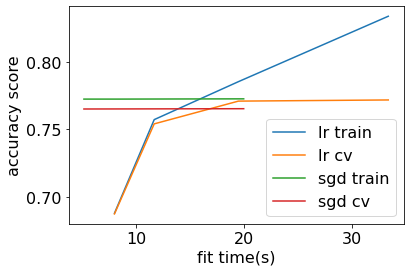

In [26]:
plt.plot(results_lr["mean_fit_time"], results_lr["mean_train_score"], label="lr train")
plt.plot(results_lr["mean_fit_time"], results_lr["mean_test_score"], label="lr cv")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_train_score"], label="sgd train")
plt.plot(results_sgd["mean_fit_time"], results_sgd["mean_test_score"], label="sgd cv")
plt.xlabel("fit time(s)");
plt.ylabel("accuracy score");
plt.legend();

<br><br>

TL;DR if you don't want to wait that long, `SGDClassifier` will probably do better on a large dataset.